<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/CFA_Inter_Marginal_Effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Confirmatory Factor Analysis (CFA),Interrelationships, Interactions and  Marginal Effects**

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
try:
    import pingouin as pg  # For correlation matrix with p-values
except ImportError:
    print("Pingouin library not found. Please install it using: pip install pingouin")
    pg = None  # Set pg to None to avoid errors later if it's not installed
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from lavaan import LavaanModel
except ImportError:
    print("Lavaan library not found. Please install it using: pip install py-lavaan")
    LavaanModel = None # Set LavaanModel to None if not installed
from sklearn.preprocessing import StandardScaler
import networkx as nx
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import Logit
from patsy.contrasts import Treatment
import warnings
import sys
warnings.filterwarnings("ignore")


Pingouin library not found. Please install it using: pip install pingouin
Lavaan library not found. Please install it using: pip install py-lavaan


# **Load Dataset**

In [2]:
# Load dataset
try:
    df = pd.read_csv('/content/ESS11.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")


Dataset loaded successfully.


# **Data cleaning & required cols**

In [3]:
# Data cleaning & required cols
key_cols = ['weighta', 'height', 'etfruit', 'eatveg', 'dosprt','mainact','slprl','alcwkdy','alcwknd',"hltprhc", "hltprhb", "hltphhc", "hltphhb",
            'cgtsmok', 'alcfreq', 'edulvlb', 'hinctnta', 'gndr', 'ppltrst', 'pplfair', 'pplhlp', 'agea']  # Added social trust vars & age

# Check that required columns exist
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")
df = df.dropna(subset=key_cols).copy()

# Convert columns to numeric, handling errors
cols_to_convert = ["hltprhc", "hltprhb", "hltphhc", "hltphhb"]
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric and coerce errors to NaN

# Impute missing values
df[cols_to_convert] = df[cols_to_convert].fillna(0)

# Add the new CVD column
df["CVD"] = df[["hltprhc", "hltprhb", "hltphhc", "hltphhb"]].sum(axis=1)

# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()

In [4]:
# Ensure CVD is binary/int (map or cast if necessary)
if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1', 'yes', 'true', 'y', 't'] else 0)
    df['CVD'] = df['CVD'].astype(int)
print(f"Unique values in CVD (Y): {np.unique(df['CVD'])}")

Unique values in CVD (Y): [0 1 2 3 4]


In [5]:
# Education level dummies
df['edulvl_low'] = np.where(df['edulvlb'] <= 3, 1, 0)
df['edulvl_med'] = np.where((df['edulvlb'] > 3) & (df['edulvlb'] <= 6), 1, 0)
df['edulvl_high'] = np.where(df['edulvlb'] > 6, 1, 0)

# Standardize hinctnta to address potential scaling issues
scaler = StandardScaler()
df['hinctnta_scaled'] = scaler.fit_transform(df[['hinctnta']])

# Reverse code social trust variables so that higher values always represent more trust/helpfulness
df['pplfair_r'] = 5 - df['pplfair']  # Assuming 1-5 scale
df['pplhlp_r'] = 5 - df['pplhlp']  # Assuming 1-5 scale


# **European Regions Mapping**

In [6]:
# European regions mapping
region_map = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East'
}
def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).upper()
    return region_map.get(c, 'Unknown')

df['region'] = df['cntry'].apply(get_region)  # Apply the mapping function to create the 'region' column


In [7]:
# Socioeconomic Status (SES)
ses_model = """
    SES =~ edulvl_low + edulvl_med + edulvl_high + hinctnta_scaled
"""

# Health Risk Behaviors
health_model = """
    Health =~ cgtsmok + alcfreq + etfruit + eatveg + dosprt
"""

# Social Trust/Cohesion
trust_model = """
    Trust =~ ppltrst + pplfair_r + pplhlp_r
"""

# Fit the CFA models
if LavaanModel is not None:
    ses_cfa = LavaanModel(model_syntax=ses_model, data=df)
    health_cfa = LavaanModel(model_syntax=health_model, data=df)
    trust_cfa = LavaanModel(model_syntax=trust_model, data=df)

    ses_results = ses_cfa.fit()
    health_results = health_cfa.fit()
    trust_results = trust_cfa.fit()

    print("\n--- CFA Results ---")

    # Print SES CFA results
    print("\nSES CFA:")
    print(ses_results.summary())
    print(f"RMSEA: {ses_results.fit['rmsea']:.3f}, CFI: {ses_results.fit['cfi']:.3f}, TLI: {ses_results.fit['tli']:.3f}, SRMR: {ses_results.fit['srmr']:.3f}")

    # Print Health CFA results
    print("\nHealth CFA:")
    print(health_results.summary())
    print(f"RMSEA: {health_results.fit['rmsea']:.3f}, CFI: {health_results.fit['cfi']:.3f}, TLI: {health_results.fit['tli']:.3f}, SRMR: {health_results.fit['srmr']:.3f}")

    # Print Trust CFA results
    print("\nTrust CFA:")
    print(trust_results.summary())
    print(f"RMSEA: {trust_results.fit['rmsea']:.3f}, CFI: {trust_results.fit['cfi']:.3f}, TLI: {trust_results.fit['tli']:.3f}, SRMR: {ses_results.fit['srmr']:.3f}")

    # Extract standardized loadings and CIs
    def extract_standardized_loadings(results):
        loadings = {}
        for param in results.parameters:
            if "~~" not in param and "=~" in param:
                loadings[param] = {
                    'estimate': results.get_parameter_values(param)[0],
                    'se': results.get_parameter_se(param)[0],
                }
        return loadings

    ses_loadings = extract_standardized_loadings(ses_results)
    health_loadings = extract_standardized_loadings(health_results)
    trust_loadings = extract_standardized_loadings(trust_results)

    print("\n--- Standardized Loadings ---")
    print("\nSES Loadings:")
    for param, values in ses_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        ci_lower_95 = estimate - 1.96 * se
        ci_upper_95 = estimate + 1.96 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}], 95% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}]")

    print("\nHealth Loadings:")
    for param, values in health_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        ci_lower_95 = estimate - 1.96 * se
        ci_upper_95 = estimate + 1.96 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}], 95% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}]")

    print("\nTrust Loadings:")
    for param, values in trust_loadings.items():
        se = values['se']
        estimate = values['estimate']
        ci_lower_90 = estimate - 1.645 * se
        ci_upper_90 = estimate + 1.645 * se
        print(f"{param}: Estimate = {estimate:.3f}, 90% CI = [{ci_lower_95:.3f}, {ci_upper_95:.3f}], 95% CI = [{ci_lower_90:.3f}, {ci_upper_90:.3f}]")

    # Save CFA fit indices to CSV
    cfa_fit = {
        'SES': {'RMSEA': ses_results.fit['rmsea'], 'CFI': ses_results.fit['cfi'], 'TLI': ses_results.fit['tli'], 'SRMR': ses_results.fit['srmr']},
        'Health': {'RMSEA': health_results.fit['rmsea'], 'CFI': health_results.fit['cfi'], 'TLI': health_results.fit['tli'], 'SRMR': health_results.fit['srmr']},
        'Trust': {'RMSEA': trust_results.fit['rmsea'], 'CFI': trust_results.fit['cfi'], 'TLI': trust_results.fit['tli'], 'SRMR': trust_results.fit['srmr']}
    }
    cfa_fit_df = pd.DataFrame(cfa_fit).T
    cfa_fit_df.to_csv('cfa_fit.csv')
    print("CFA fit indices saved to cfa_fit.csv")
else:
    print("Skipping CFA analysis because Lavaan is not installed.")


Skipping CFA analysis because Lavaan is not installed.


In [8]:
# Pairwise Correlation Matrix
# Variables for correlation matrix
correlation_vars = ['CVD', 'BMI', 'edulvl_low', 'edulvl_med', 'edulvl_high', 'hinctnta_scaled','mainact','slprl','alcwkdy','alcwknd',
                    'cgtsmok', 'alcfreq', 'etfruit', 'eatveg', 'dosprt', 'ppltrst', 'pplfair_r', 'pplhlp_r', 'region'] #added region

# Add new variables
df['mainact'] = pd.to_numeric(df['mainact'], errors='coerce')
df['slprl'] = pd.to_numeric(df['slprl'], errors='coerce')
df['alcwkdy'] = pd.to_numeric(df['alcwkdy'], errors='coerce')
df['alcwknd'] = pd.to_numeric(df['alcwknd'], errors='coerce')

# Impute missing values for new variables with the mean
df['mainact'] = df['mainact'].fillna(df['mainact'].mean())
df['slprl'] = df['slprl'].fillna(df['slprl'].mean())
df['alcwkdy'] = df['alcwkdy'].fillna(df['alcwkdy'].mean())
df['alcwknd'] = df['alcwknd'].fillna(df['alcwknd'].mean())

# Calculate the correlation matrix with p-values using pingouin
if pg is not None:
    # One-hot encode the 'region' column
    df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)  # Use drop_first to avoid multicollinearity

    # Update correlation_vars to include one-hot encoded region columns
    correlation_vars_updated = correlation_vars[:-1]  # Exclude the original 'region' column
    correlation_vars_updated.extend([col for col in df.columns if col.startswith('region_')])  # Add one-hot encoded columns


    corr_matrix = pg.pairwise_corr(df[correlation_vars_updated], method='pearson', alternative='two-sided')

    # Pivot the correlation matrix for better readability
    corr_matrix_pivot = corr_matrix.pivot(index='X', columns='Y', values='r')
    p_matrix_pivot = corr_matrix.pivot(index='X', columns='Y', values='p-unc')

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(16, 14)) # Increased figure size for better readability
    heatmap = sns.heatmap(corr_matrix_pivot, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # store the heatmap object
    plt.title('Pairwise Correlation Matrix', fontsize=16, fontweight='bold', color='#3f8a74')
    plt.tight_layout()
    plt.gca().set_facecolor('#fffedc')
    plt.savefig('correlation_heatmap.png')
    plt.show()
    print("Correlation heatmap saved to correlation_heatmap.png")

    # Print the correlation matrix and p-value matrix
    print("\n--- Correlation Matrix ---")
    print(corr_matrix_pivot)
    print("\n--- P-value Matrix ---")
    print(p_matrix_pivot)

    # Save the correlation matrix to a CSV file
    corr_matrix_pivot.to_csv('correlation_matrix.csv')
    print("Correlation matrix saved to correlation_matrix.csv")
else:
    print("Skipping correlation analysis because Pingouin is not installed.")

Skipping correlation analysis because Pingouin is not installed.



--- Interaction Model Results ---

Model 1: BMI x Education
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CVD   No. Observations:                46162
Model:                            GLM   Df Residuals:                    46152
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 06 Oct 2025   Deviance:                   3.0404e+06
Time:                        02:48:51   Pearson chi2:                 1.95e+20
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

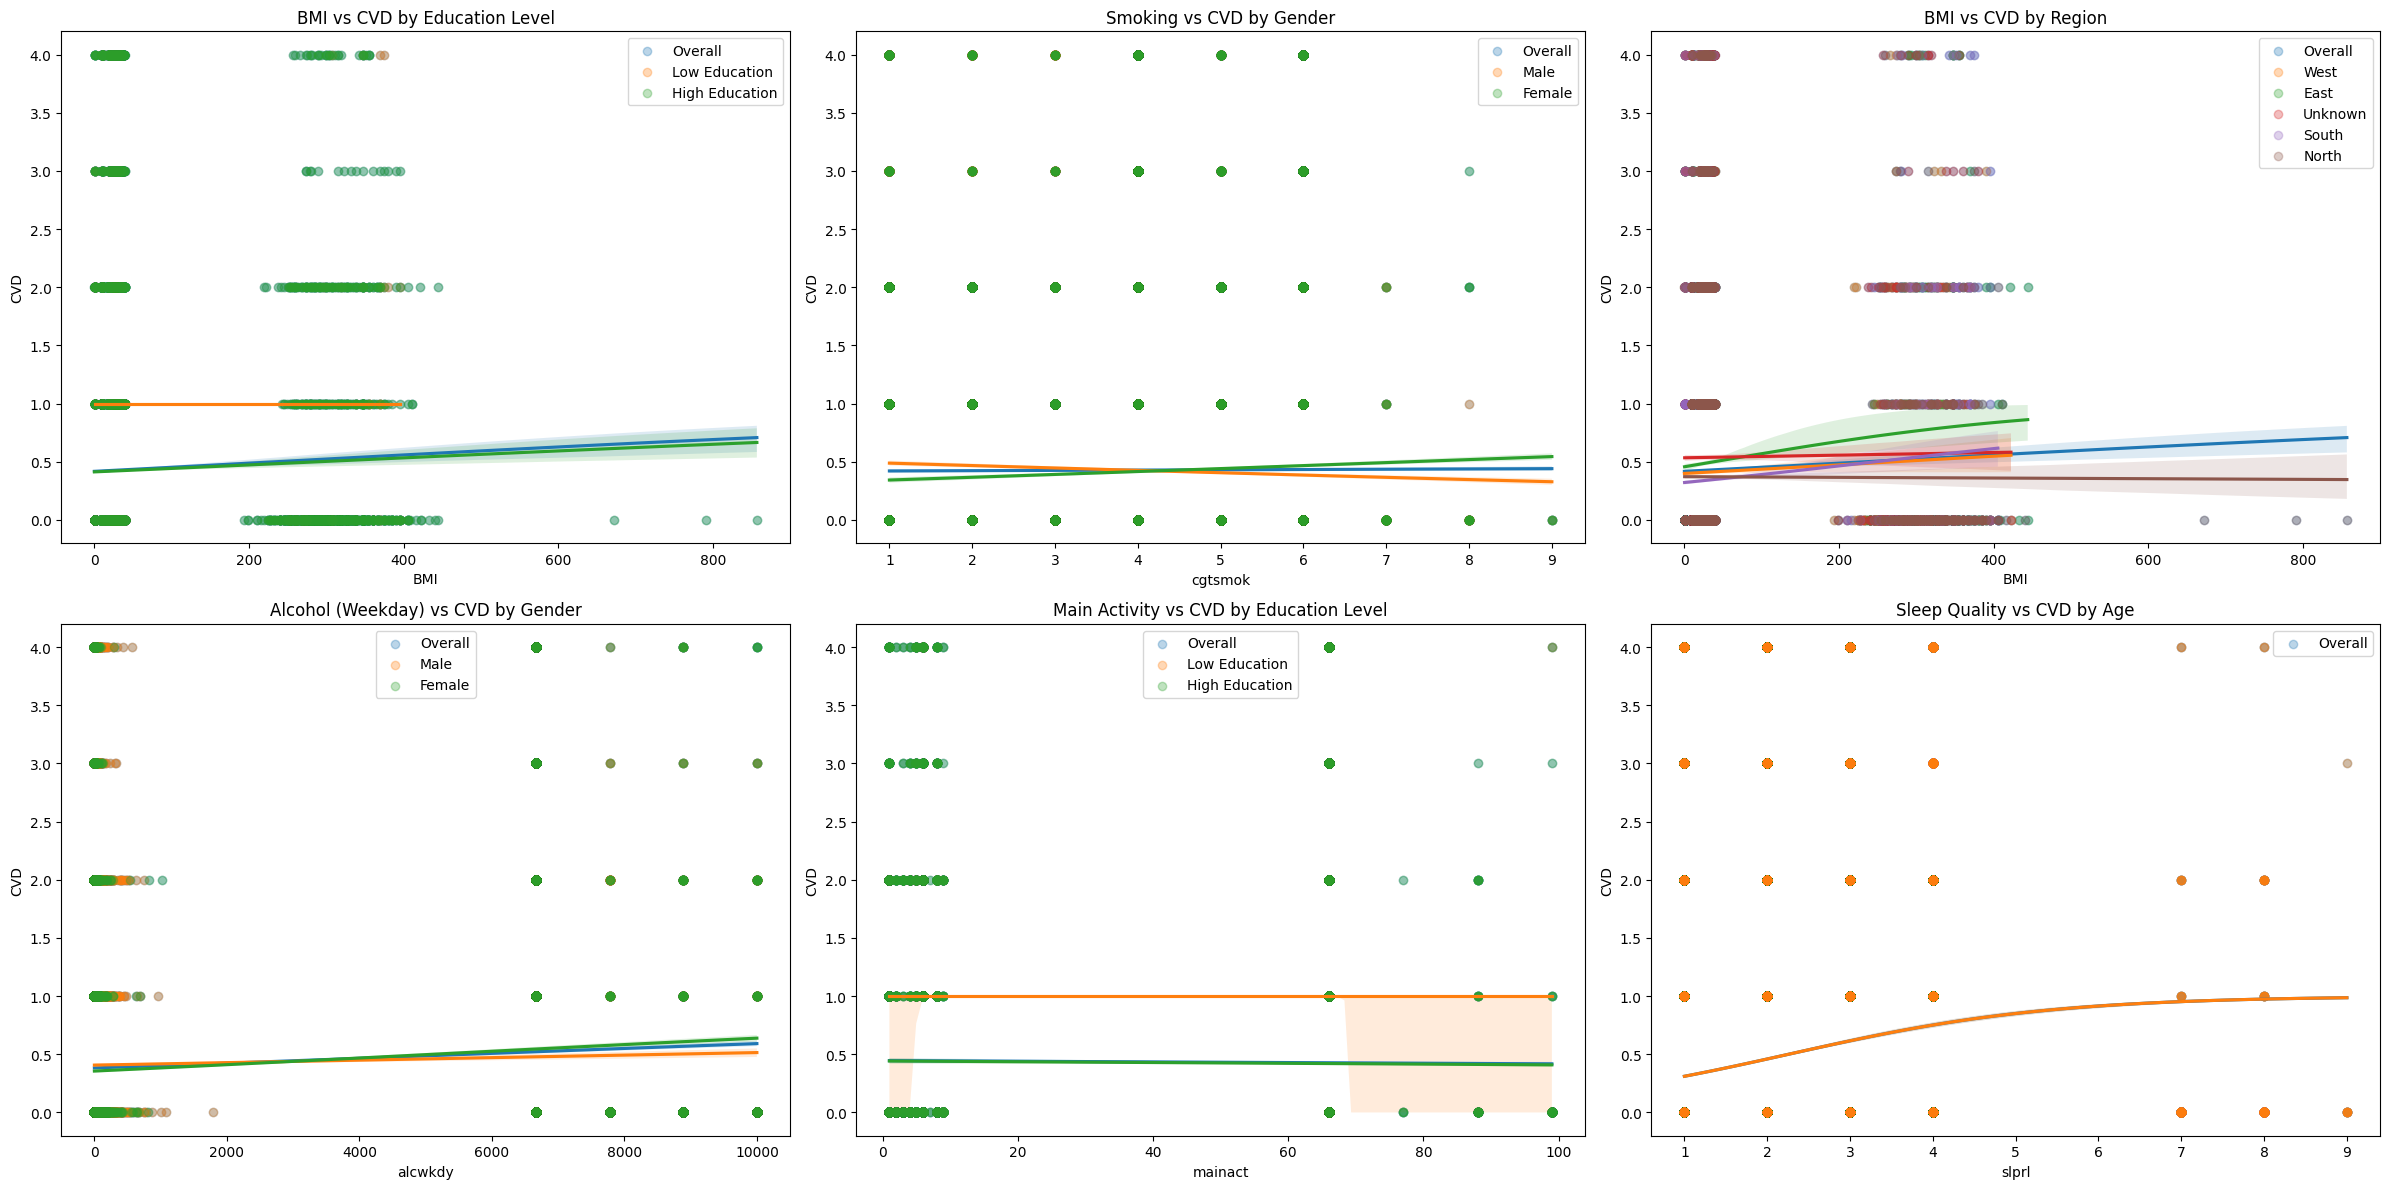

Interaction plots saved to interaction_plots.png


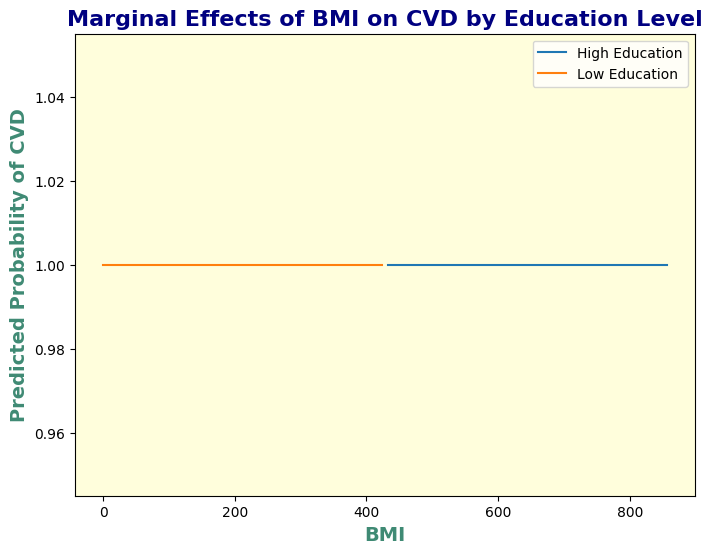

Marginal effects plot (BMI x Education) saved to marginal_effects_bmi_education.png


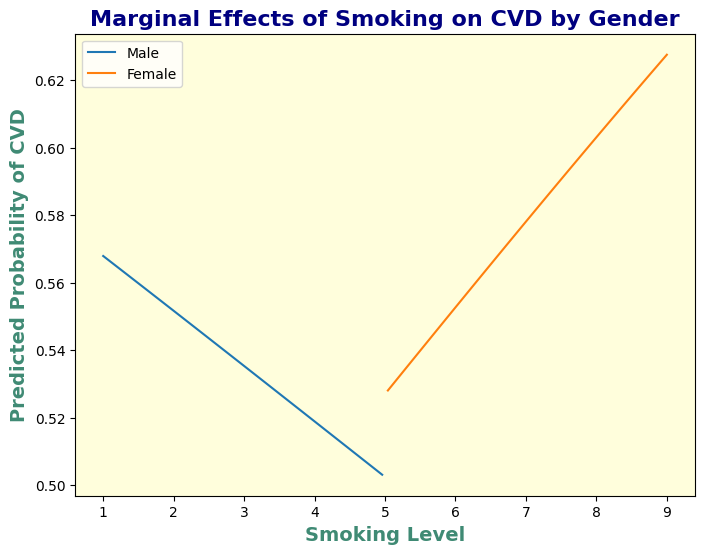

Marginal effects plot (Smoking x Gender) saved to marginal_effects_smoking_gender.png


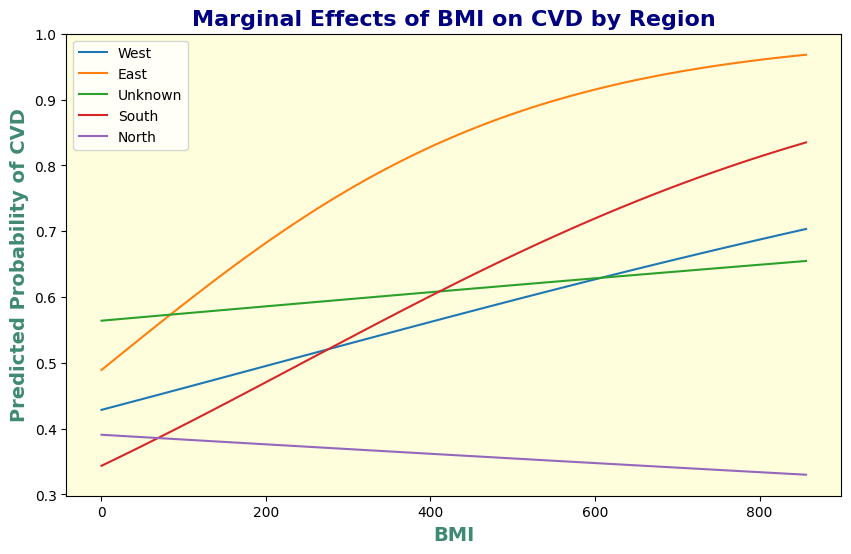

Marginal effects plot (Region x BMI) saved to marginal_effects_region_bmi.png


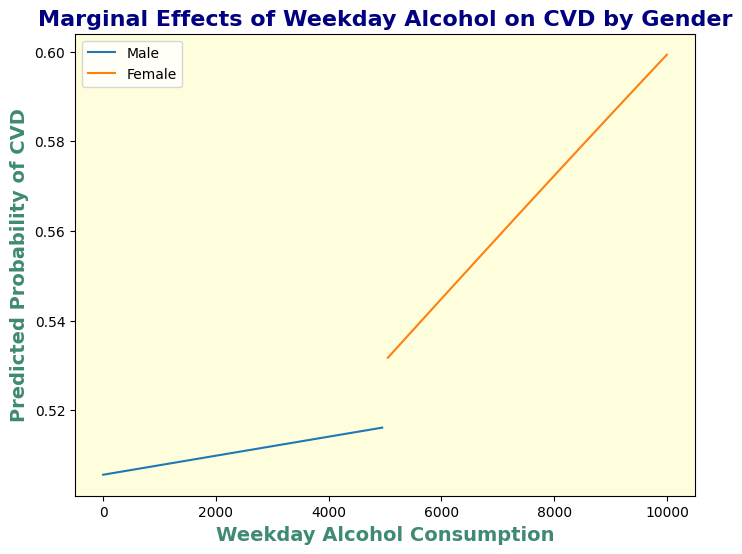

Marginal effects plot (Alcohol x Gender) saved to marginal_effects_alcohol_gender.png


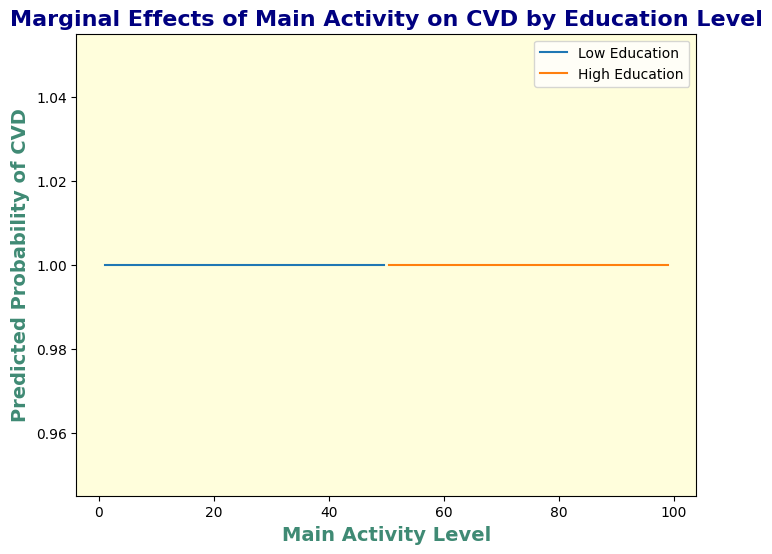

Marginal effects plot (Main Activity x Education) saved to marginal_effects_mainact_education.png


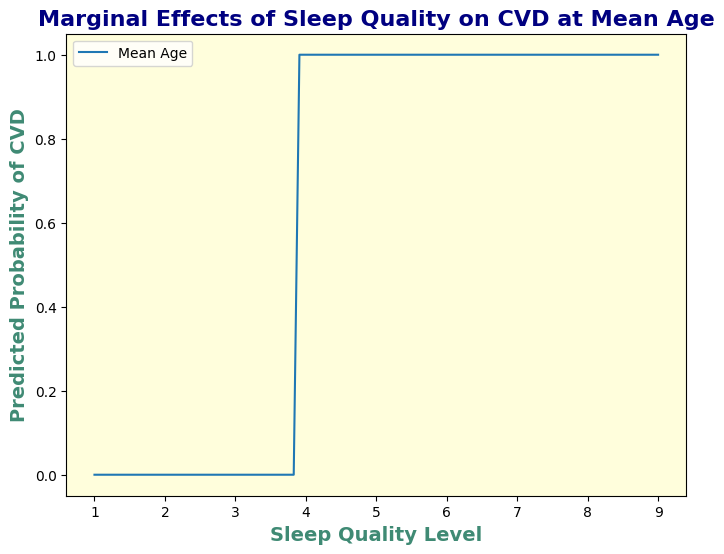

Marginal effects plot (Sleep Quality x Age) saved to marginal_effects_sleep_age.png


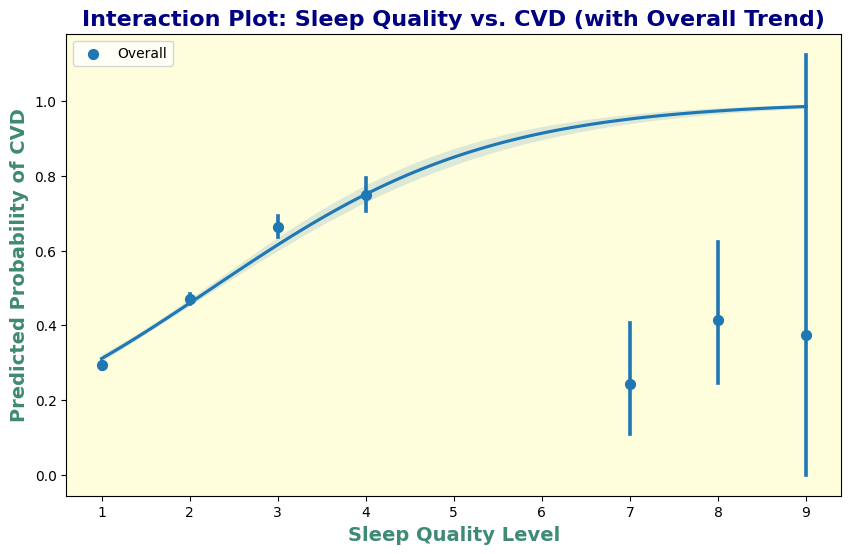

Interaction plot for Sleep Quality and CVD saved to interaction_plot_sleep_quality_cvd.png


In [9]:
# Logistic regression with interaction terms

# Model 1: BMI x education
model1 = smf.glm(formula='CVD ~ BMI * edulvl_high + agea + gndr + region', data=df, family=Binomial(link=Logit())).fit() #added region

# Model 2: Smoking x gender
model2 = smf.glm(formula='CVD ~ cgtsmok * gndr + agea + BMI + region', data=df, family=Binomial(link=Logit())).fit() #added region

# Model 3: Region x BMI
model3 = smf.glm(formula='CVD ~ region * BMI + agea + gndr + cgtsmok', data=df, family=Binomial(link=Logit())).fit()  # Added Model 3

# Model 4: Alcohol Consumption x Gender
model4 = smf.glm(formula='CVD ~ (alcwkdy + alcwknd) * gndr + agea + BMI + region + cgtsmok', data=df, family=Binomial(link=Logit())).fit()

# Model 5: Main Activity x Socioeconomic Status (SES proxy by edulvl_high)
model5 = smf.glm(formula='CVD ~ mainact * edulvl_high + agea + BMI + region + cgtsmok + (alcwkdy + alcwknd)', data=df, family=Binomial(link=Logit())).fit()

# Model 6: Sleep Quality x Age
model6 = smf.glm(formula='CVD ~ slprl * agea + BMI + region + cgtsmok + (alcwkdy + alcwknd) + edulvl_high', data=df, family=Binomial(link=Logit())).fit()

print("\n--- Interaction Model Results ---")
print("\nModel 1: BMI x Education")
print(model1.summary())

print("\nModel 2: Smoking x Gender")
print(model2.summary())

print("\nModel 3: Region x BMI")  # Print results for Model 3
print(model3.summary())

print("\nModel 4: Alcohol Consumption x Gender")
print(model4.summary())

print("\nModel 5: Main Activity x Education")
print(model5.summary())

print("\nModel 6: Sleep Quality x Age")
print(model6.summary())

# Coefficient plots
fig, axes = plt.subplots(2, 3, figsize=(24, 12)) #Increased to accommodate 6 plots

# Model 1
sns.regplot(x='BMI', y='CVD', data=df, logistic=True, ax=axes[0,0], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='BMI', y='CVD', data=df[df['edulvl_high'] == 0], logistic=True, ax=axes[0,0], label='Low Education', scatter_kws={'alpha':0.3})
sns.regplot(x='BMI', y='CVD', data=df[df['edulvl_high'] == 1], logistic=True, ax=axes[0,0], label='High Education', scatter_kws={'alpha':0.3})
axes[0,0].set_title('BMI vs CVD by Education Level')
axes[0,0].legend()

# Model 2
sns.regplot(x='cgtsmok', y='CVD', data=df, logistic=True, ax=axes[0,1], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='cgtsmok', y='CVD', data=df[df['gndr'] == 1], logistic=True, ax=axes[0,1], label='Male', scatter_kws={'alpha':0.3})
sns.regplot(x='cgtsmok', y='CVD', data=df[df['gndr'] == 2], logistic=True, ax=axes[0,1], label='Female', scatter_kws={'alpha':0.3})
axes[0,1].set_title('Smoking vs CVD by Gender')
axes[0,1].legend()

# Model 3
regions = df['region'].unique()
sns.regplot(x='BMI', y='CVD', data=df, logistic=True, ax=axes[0,2], label='Overall', scatter_kws={'alpha': 0.3})
for region in regions:
    sns.regplot(x='BMI', y='CVD', data=df[df['region'] == region], logistic=True, ax=axes[0,2], label=region, scatter_kws={'alpha': 0.3})
axes[0,2].set_title('BMI vs CVD by Region')
axes[0,2].legend()

# Model 4: Alcohol Consumption x Gender
sns.regplot(x='alcwkdy', y='CVD', data=df, logistic=True, ax=axes[1,0], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='alcwkdy', y='CVD', data=df[df['gndr'] == 1], logistic=True, ax=axes[1,0], label='Male', scatter_kws={'alpha':0.3})
sns.regplot(x='alcwkdy', y='CVD', data=df[df['gndr'] == 2], logistic=True, ax=axes[1,0], label='Female', scatter_kws={'alpha':0.3})
axes[1,0].set_title('Alcohol (Weekday) vs CVD by Gender')
axes[1,0].legend()

# Model 5: Main Activity x Education Level
sns.regplot(x='mainact', y='CVD', data=df, logistic=True, ax=axes[1,1], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='mainact', y='CVD', data=df[df['edulvl_high'] == 0], logistic=True, ax=axes[1,1], label='Low Education', scatter_kws={'alpha':0.3})
sns.regplot(x='mainact', y='CVD', data=df[df['edulvl_high'] == 1], logistic=True, ax=axes[1,1], label='High Education', scatter_kws={'alpha':0.3})
axes[1,1].set_title('Main Activity vs CVD by Education Level')
axes[1,1].legend()

# Model 6: Sleep Quality x Age
sns.regplot(x='slprl', y='CVD', data=df, logistic=True, ax=axes[1,2], label='Overall', scatter_kws={'alpha':0.3})
sns.regplot(x='slprl', y='CVD', data=df, logistic=True, ax=axes[1,2], scatter_kws={'alpha':0.3})
axes[1,2].set_title('Sleep Quality vs CVD by Age')
axes[1,2].legend()

plt.tight_layout()
plt.savefig('interaction_plots.png')
plt.show()
print("Interaction plots saved to interaction_plots.png")

# Marginal effects for Model 1 (BMI x Education)
# Create a range of BMI values
bmi_range = np.linspace(df['BMI'].min(), df['BMI'].max(), 100)

# To predict using statsmodels with a formula, create a DataFrame
# with the values to predict over.
new_data_bmi_edu = pd.DataFrame({
    'BMI': bmi_range,
    'edulvl_high': np.concatenate([np.zeros(50), np.ones(50)]),  # Example: first half low, second half high
    'agea': np.full(100, df['agea'].mean()),
    'gndr': np.full(100, df['gndr'].mean()),
    'region': np.full(100, df['region'].mode()[0])  # Set to most frequent region for prediction.
})

# Predict CVD probability
pred_bmi_edu = model1.predict(new_data_bmi_edu)

# Separate predictions for high and low education
pred_low_edu = pred_bmi_edu[:50]
pred_high_edu = pred_bmi_edu[50:]

# Create BMI range for each education level
bmi_range_low_edu = bmi_range[:50]
bmi_range_high_edu = bmi_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(bmi_range_high_edu, pred_high_edu, label='High Education')
plt.plot(bmi_range_low_edu, pred_low_edu, label='Low Education')
plt.xlabel('BMI', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of BMI on CVD by Education Level', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_bmi_education.png')
plt.show()
print("Marginal effects plot (BMI x Education) saved to marginal_effects_bmi_education.png")

# Marginal effects for Model 2 (Smoking x Gender)
smoking_range = np.linspace(df['cgtsmok'].min(), df['cgtsmok'].max(), 100)

# Create DataFrame for prediction
new_data_smoking_gender = pd.DataFrame({
    'cgtsmok': smoking_range,
    'gndr': np.concatenate([np.ones(50), np.full(50, 2)]),  # Example: first half Male, second half Female
    'agea': np.full(100, df['agea'].mean()),
    'BMI': np.full(100, df['BMI'].mean()),
    'region': np.full(100, df['region'].mode()[0])  # Set to most frequent region for prediction
})

# Predict CVD probability
pred_smoking_gender = model2.predict(new_data_smoking_gender)

# Separate predictions for male and female
pred_male = pred_smoking_gender[:50]
pred_female = pred_smoking_gender[50:]

# Create smoking range for each gender
smoking_range_male = smoking_range[:50]
smoking_range_female = smoking_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(smoking_range_male, pred_male, label='Male')
plt.plot(smoking_range_female, pred_female, label='Female')
plt.xlabel('Smoking Level', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of Smoking on CVD by Gender', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_smoking_gender.png')
plt.show()
print("Marginal effects plot (Smoking x Gender) saved to marginal_effects_smoking_gender.png")

# Marginal effects for Model 3 (Region x BMI)
bmi_range = np.linspace(df['BMI'].min(), df['BMI'].max(), 100)
regions = df['region'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Loop through each region and plot the marginal effect of BMI
for region in regions:
    new_data_region_bmi = pd.DataFrame({
        'BMI': bmi_range,
        'region': [region] * 100,  # Set region for all BMI values
        'agea': np.full(100, df['agea'].mean()),
        'gndr': np.full(100, df['gndr'].mean()),
        'cgtsmok': np.full(100, df['cgtsmok'].mean())  # Set to mean smoking level
    })

    pred_region_bmi = model3.predict(new_data_region_bmi)
    plt.plot(bmi_range, pred_region_bmi, label=region)

plt.xlabel('BMI', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of BMI on CVD by Region', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_region_bmi.png')
plt.show()
print("Marginal effects plot (Region x BMI) saved to marginal_effects_region_bmi.png")

# Marginal effects for Model 4 (Alcohol Consumption x Gender)
alcwkdy_range = np.linspace(df['alcwkdy'].min(), df['alcwkdy'].max(), 100)

# Create DataFrame for prediction
new_data_alcohol_gender = pd.DataFrame({
    'alcwkdy': alcwkdy_range,
    'alcwknd': np.full(100, df['alcwknd'].mean()),  # Hold weekend alcohol consumption constant
    'gndr': np.concatenate([np.ones(50), np.full(50, 2)]),  # First half Male, second half Female
    'agea': np.full(100, df['agea'].mean()),
    'BMI': np.full(100, df['BMI'].mean()),
    'region': np.full(100, df['region'].mode()[0]),  # Set to most frequent region
    'cgtsmok': np.full(100, df['cgtsmok'].mean())
})

# Predict CVD probability
pred_alcohol_gender = model4.predict(new_data_alcohol_gender)

# Separate predictions for male and female
pred_male = pred_alcohol_gender[:50]
pred_female = pred_alcohol_gender[50:]

# Create alcwkdy range for each gender
alcwkdy_range_male = alcwkdy_range[:50]
alcwkdy_range_female = alcwkdy_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(alcwkdy_range_male, pred_male, label='Male')
plt.plot(alcwkdy_range_female, pred_female, label='Female')
plt.xlabel('Weekday Alcohol Consumption', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of Weekday Alcohol on CVD by Gender', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_alcohol_gender.png')
plt.show()
print("Marginal effects plot (Alcohol x Gender) saved to marginal_effects_alcohol_gender.png")

# Marginal effects for Model 5 (Main Activity x Education)
mainact_range = np.linspace(df['mainact'].min(), df['mainact'].max(), 100)

# Create DataFrame for prediction
new_data_mainact_edu = pd.DataFrame({
    'mainact': mainact_range,
    'edulvl_high': np.concatenate([np.zeros(50), np.ones(50)]),  # First half low education, second half high
    'agea': np.full(100, df['agea'].mean()),
    'BMI': np.full(100, df['BMI'].mean()),
    'region': np.full(100, df['region'].mode()[0]),  # Set to most frequent region
    'cgtsmok': np.full(100, df['cgtsmok'].mean()),
    'alcwkdy': np.full(100, df['alcwkdy'].mean()),
    'alcwknd': np.full(100, df['alcwknd'].mean())
})

# Predict CVD probability
pred_mainact_edu = model5.predict(new_data_mainact_edu)

# Separate predictions for low and high education
pred_low_edu = pred_mainact_edu[:50]
pred_high_edu = pred_mainact_edu[50:]

# Create mainact range for each education level
mainact_range_low_edu = mainact_range[:50]
mainact_range_high_edu = mainact_range[50:]

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(mainact_range_low_edu, pred_low_edu, label='Low Education')
plt.plot(mainact_range_high_edu, pred_high_edu, label='High Education')
plt.xlabel('Main Activity Level', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of Main Activity on CVD by Education Level', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_mainact_education.png')
plt.show()
print("Marginal effects plot (Main Activity x Education) saved to marginal_effects_mainact_education.png")

# Marginal effects for Model 6 (Sleep Quality x Age)
slprl_range = np.linspace(df['slprl'].min(), df['slprl'].max(), 100)

# Create DataFrame for prediction
new_data_sleep_age = pd.DataFrame({
    'slprl': slprl_range,
    'agea': np.full(100, df['agea'].mean()),  # Hold age constant at the mean
    'BMI': np.full(100, df['BMI'].mean()),
    'region': np.full(100, df['region'].mode()[0]),  # Set to most frequent region
    'cgtsmok': np.full(100, df['cgtsmok'].mean()),
    'alcwkdy': np.full(100, df['alcwkdy'].mean()),
    'alcwknd': np.full(100, df['alcwknd'].mean()),
    'edulvl_high': np.full(100, df['edulvl_high'].mean())
})

# Predict CVD probability
pred_sleep_age = model6.predict(new_data_sleep_age)

# Plot marginal effects
plt.figure(figsize=(8, 6))
plt.plot(slprl_range, pred_sleep_age, label='Mean Age')
plt.xlabel('Sleep Quality Level', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Marginal Effects of Sleep Quality on CVD at Mean Age', fontsize=16, fontweight='bold', color='navy')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('marginal_effects_sleep_age.png')
plt.show()
print("Marginal effects plot (Sleep Quality x Age) saved to marginal_effects_sleep_age.png")

# Interaction Plot for Model 6 (Sleep Quality x Age)
# Create a scatter plot with regression lines
plt.figure(figsize=(10, 6))
sns.regplot(x='slprl', y='CVD', data=df, x_estimator=np.mean, logistic=True, label='Overall')
plt.title('Interaction Plot: Sleep Quality vs. CVD (with Overall Trend)', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Sleep Quality Level', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Predicted Probability of CVD', fontsize=14, fontweight='bold', color='#3f8a74')
plt.legend()
plt.gca().set_facecolor('#fffedc')
plt.savefig('interaction_plot_sleep_quality_cvd.png')
plt.show()
print("Interaction plot for Sleep Quality and CVD saved to interaction_plot_sleep_quality_cvd.png")


In [10]:
# Mediation
try:
    from causal_mediation import CausalMediation
    print("Causal mediation package is available.")
except ImportError:
    print("Causal mediation package not found. Skipping mediation analysis.")
    CausalMediation = None

if 'causal_mediation' in sys.modules:
    # Mediation: SES -> Smoking -> CVD
    # Here, SES is proxied by edulvl_high (high education level)
    # Mediator is cgtsmok (smoking)
    # Outcome is CVD
    mediation_model = CausalMediation(
        data=df,
        outcome='CVD',
        treatment='edulvl_high',
        mediator='cgtsmok',
        confounders=['agea', 'gndr', 'BMI', 'region'])
    mediation_results = mediation_model.fit()

    # Print mediation results
    print("\n--- Mediation Analysis Results ---")
    print(mediation_results.summary())


Causal mediation package not found. Skipping mediation analysis.


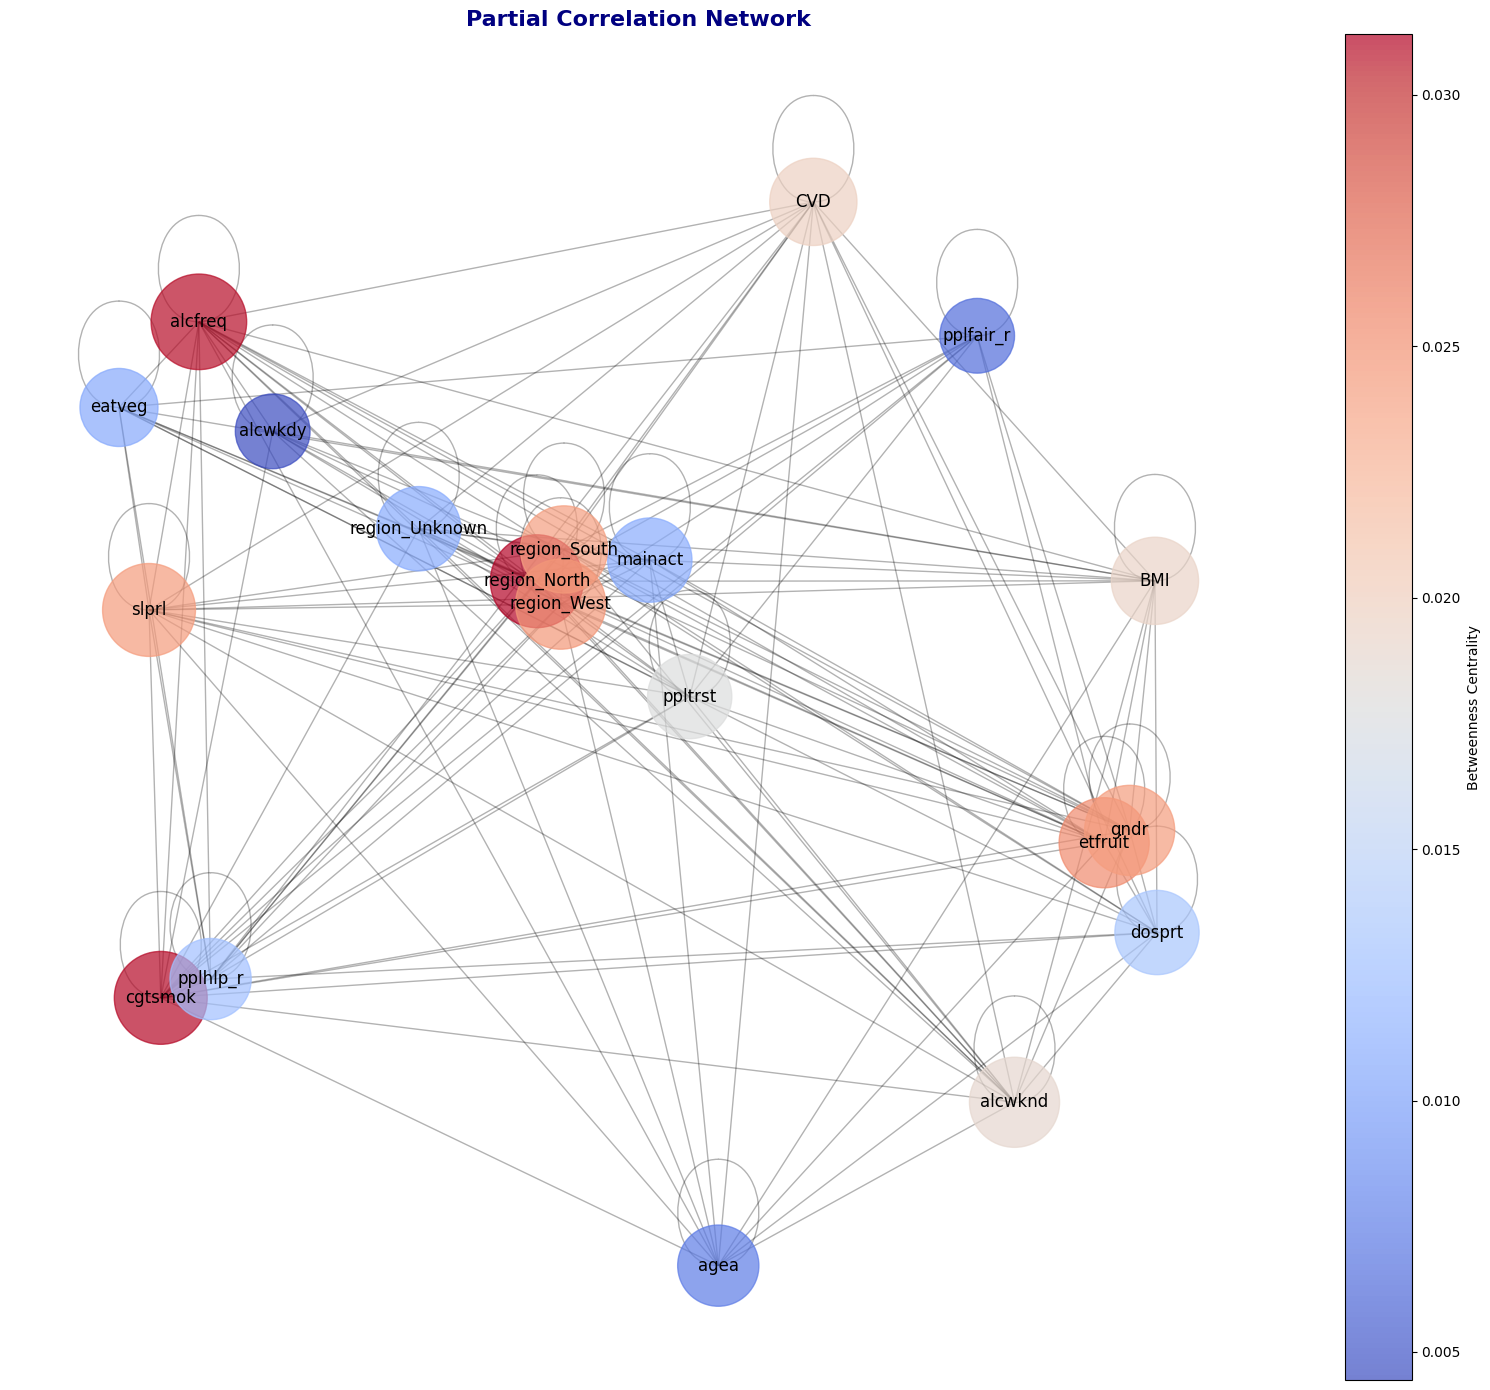

Network graph saved to fig_network.png


In [11]:
# Network Analysis
from sklearn.covariance import GraphicalLassoCV

# Select variables for network analysis
network_vars = ['CVD', 'BMI', 'cgtsmok', 'alcfreq', 'etfruit', 'eatveg', 'dosprt','mainact','slprl','alcwkdy','alcwknd',
                'ppltrst', 'pplfair_r', 'pplhlp_r', 'agea', 'gndr','region'] #added region

# One-Hot Encode 'region' for Network Analysis
df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)

# Update network_vars to include one-hot encoded region columns
network_vars_updated = network_vars[:-1]  # Exclude the original 'region' column
network_vars_updated.extend([col for col in df.columns if col.startswith('region_')])  # Add one-hot encoded columns

# Drop rows with missing values in the selected variables
network_data = df[network_vars_updated].dropna()

# Standardize the data
scaler = StandardScaler()
network_data_scaled = scaler.fit_transform(network_data)

# Estimate the precision matrix using GraphicalLassoCV
model = GraphicalLassoCV(cv=5, verbose=False, max_iter=500)
model.fit(network_data_scaled)
covariance = model.covariance_
precision = model.precision_

# Create the graph from the precision matrix
graph = nx.from_numpy_array(precision)

# Relabel nodes with variable names
mapping = {i: var for i, var in enumerate(network_vars_updated)}
graph = nx.relabel_nodes(graph, mapping)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

# Visualize the network with centrality as node size and color
plt.figure(figsize=(16, 14)) # Increased figure size for better readability
node_size = [v * 5000 for v in degree_centrality.values()]
node_color = [v for v in betweenness_centrality.values()]

pos = nx.spring_layout(graph, seed=42)  # You can try different layouts

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.coolwarm, alpha=0.7) # Store the node object
nx.draw_networkx_edges(graph, pos, alpha=0.3)
nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')

plt.title("Partial Correlation Network", fontsize=16, fontweight='bold', color='navy')
plt.colorbar(nodes, label="Betweenness Centrality")
plt.axis('off')
plt.tight_layout()
plt.gca().set_facecolor('#fffedc')
plt.savefig('fig_network.png')
plt.show()
print("Network graph saved to fig_network.png")


In [12]:
# Print centrality measures
print("\n--- Centrality Measures ---")
print("\nDegree Centrality:", degree_centrality)
print("\nBetweenness Centrality:", betweenness_centrality)
print("\nEigenvector Centrality:", eigenvector_centrality)


--- Centrality Measures ---

Degree Centrality: {'CVD': 0.7894736842105263, 'BMI': 0.7894736842105263, 'cgtsmok': 0.894736842105263, 'alcfreq': 0.9473684210526315, 'etfruit': 0.8421052631578947, 'eatveg': 0.631578947368421, 'dosprt': 0.7368421052631579, 'mainact': 0.7368421052631579, 'slprl': 0.894736842105263, 'alcwkdy': 0.5789473684210527, 'alcwknd': 0.8421052631578947, 'ppltrst': 0.7368421052631579, 'pplfair_r': 0.5789473684210527, 'pplhlp_r': 0.6842105263157894, 'agea': 0.6842105263157894, 'gndr': 0.8421052631578947, 'region_North': 0.894736842105263, 'region_South': 0.7894736842105263, 'region_Unknown': 0.7368421052631579, 'region_West': 0.8421052631578947}

Betweenness Centrality: {'CVD': 0.019797600060757953, 'BMI': 0.019340860568930744, 'cgtsmok': 0.0310857109102723, 'alcfreq': 0.030983814755744573, 'etfruit': 0.025402099524906546, 'eatveg': 0.010693822097330868, 'dosprt': 0.013304726462621198, 'mainact': 0.010865969637899462, 'slprl': 0.024337358547884862, 'alcwkdy': 0.004442

### **See Part 2: CFA Inter-Marginal Effect**